In [ ]:
!pip install tensorflow-gpu
	
!pip install h5py

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading the .csv

In [ ]:
df_csv = pd.read_csv("/content/drive/MyDrive/DataSets/Dog_Breed_Classification/labels.csv")
columns = df_csv['breed'].unique()
print(len(columns))
# print(columns)
print(df_csv.shape)
breed_count = df_csv.breed.value_counts()

120
(10222, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


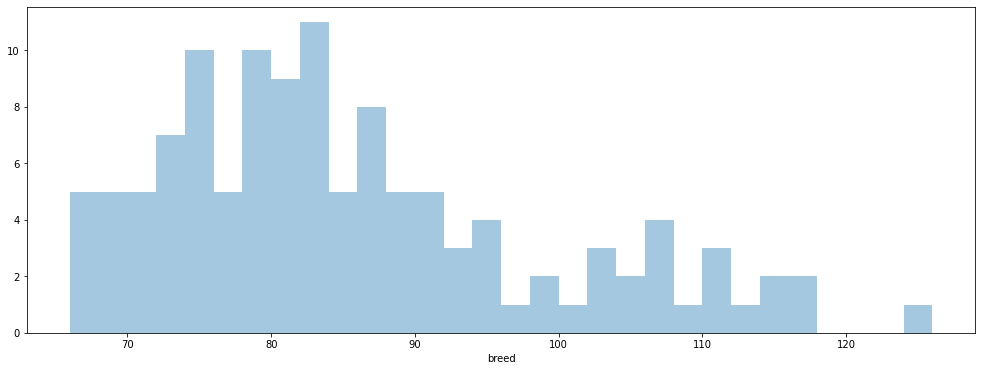

In [ ]:
plt.figure(figsize=(17,6))
sb.distplot(breed_count,bins=30, kde=None )

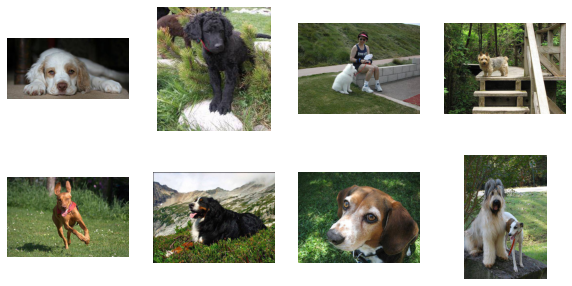

In [ ]:
src_path = "/content/drive/MyDrive/DataSets/Dog_Breed_Classification/train"
sub_class = os.listdir(src_path)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:8])):
    plt.subplot(2,4,e+1)
    img = plt.imread(os.path.join(src_path,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

Performing one hot encoding of breeds and generating absolute path for train folder

In [ ]:
df_csv_onehot = pd.get_dummies(df_csv['breed'],drop_first= False) 
df_csv_final = pd.concat((df_csv, df_csv_onehot),axis=1)
df_csv_final['abs_path_train'] = "/content/drive/MyDrive/DataSets/Dog_Breed_Classification/train" + '/' + df_csv.id + ".jpg"
#df_csv_final['labels_encoded'] = df_csv.breed.astype('category').cat.codes
df_csv_final.drop('breed',axis=1,inplace=True)
df_csv_final.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier,abs_path_train
0,000bec180eb18c7604dcecc8fe0dba07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/DataSets/Dog_Breed_Clas...
1,001513dfcb2ffafc82cccf4d8bbaba97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/DataSets/Dog_Breed_Clas...
2,001cdf01b096e06d78e9e5112d419397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/DataSets/Dog_Breed_Clas...
3,00214f311d5d2247d5dfe4fe24b2303d,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/DataSets/Dog_Breed_Clas...
4,0021f9ceb3235effd7fcde7f7538ed62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/DataSets/Dog_Breed_Clas...


Creating a test dataframe and generating absolute path for test folder

In [ ]:
test_img = "/content/drive/MyDrive/DataSets/Dog_Breed_Classification/test"
test_img_path = os.listdir(test_img)
df_test = pd.DataFrame (test_img_path, columns= ['abs_path_test'])
df_test['abs_path_test'] = "/content/drive/MyDrive/DataSets/Dog_Breed_Classification/test" + '/' + df_test
print(df_test['abs_path_test'])

0        /content/drive/MyDrive/DataSets/Dog_Breed_Clas...
1        /content/drive/MyDrive/DataSets/Dog_Breed_Clas...
2        /content/drive/MyDrive/DataSets/Dog_Breed_Clas...
3        /content/drive/MyDrive/DataSets/Dog_Breed_Clas...
4        /content/drive/MyDrive/DataSets/Dog_Breed_Clas...
                               ...                        
10352    /content/drive/MyDrive/DataSets/Dog_Breed_Clas...
10353    /content/drive/MyDrive/DataSets/Dog_Breed_Clas...
10354    /content/drive/MyDrive/DataSets/Dog_Breed_Clas...
10355    /content/drive/MyDrive/DataSets/Dog_Breed_Clas...
10356    /content/drive/MyDrive/DataSets/Dog_Breed_Clas...
Name: abs_path_test, Length: 10357, dtype: object


Performing Data Augmentation

In [ ]:
train_gen = ImageDataGenerator(rotation_range=45,
rescale=1./255,
horizontal_flip=True,
width_shift_range = 0.2,
height_shift_range = 0.2,
fill_mode = 'nearest',
shear_range = 0.2
)
valid_gen = ImageDataGenerator(rotation_range=45,
                               rescale=1./255,
                               horizontal_flip=True,
              
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               fill_mode = 'nearest',
                               shear_range = 0.2
                               )
test_gen = ImageDataGenerator(rescale=1./255)

Associating the images with breeds using flow_from_dataframe

In [ ]:
train_data = train_gen.flow_from_dataframe(dataframe = df_csv_final[:7667], 
directory = None, x_col = 'abs_path_train',
y_col = columns, seed = 42,
validate_filenames=True,
batch_size = 32, 
shuffle = True, 
class_mode="raw", target_size = (224, 224))

validation_data = test_gen.flow_from_dataframe(dataframe = df_csv_final[7667:10222], 
directory = None, x_col = 'abs_path_train',
y_col = columns, seed = 42,
validate_filenames=True,
batch_size = 32, 
shuffle = True, 
class_mode="raw", target_size = (224, 224))

test_data = test_gen.flow_from_dataframe(dataframe = df_test, 
directory = None, x_col = 'abs_path_test', 
y_col = None,
batch_size = 32, shuffle = True, 
validate_filenames=True,
class_mode=None,target_size = (224, 224))

Found 7667 validated image filenames.
Found 2555 validated image filenames.
Found 10357 validated image filenames.


In [ ]:
x,y = next(train_data)
print(type(x))
print(x.shape)
print(y.shape)

<class 'numpy.ndarray'>
(32, 224, 224, 3)
(32, 120)


Displaying the augmented images

In [ ]:
def show_grid(image_list,nrows,ncols,figsize=(10,10),showaxis='off'):
    
    image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')

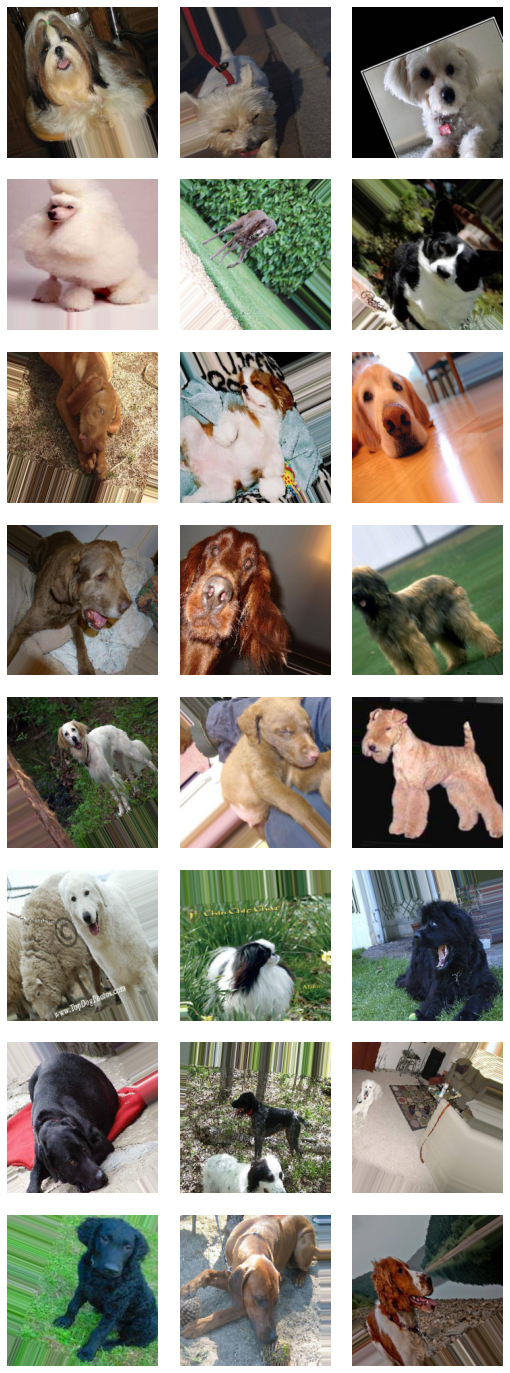

In [ ]:
show_grid(x,8,3,figsize=(25,25))

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adagrad
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D

Model 1 CNN with 4 Conv layers

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3),activation='relu',input_shape= (224,224,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120,activation='relu'),
        tf.keras.layers.Dense(120,activation='softmax')])

Implementing early stopping

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopper = EarlyStopping(monitor = 'val_loss', mode='min', verbose=1)
checkpointer = ModelCheckpoint(filepath = '/content/drive/MyDrive/DataSets/Dog_Breed_Classification/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose=1)

In [ ]:

model.compile(optimizer=Adagrad(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       18560     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

In [ ]:
r = model.fit(train_data,
     validation_data = validation_data,
     epochs=20,
     steps_per_epoch = len(train_data),
     validation_steps = len(validation_data),
     callbacks=[checkpointer, early_stopper])

Epoch 1/20
240/240 [==============================] - 2521s 10s/step - loss: 4.7879 - accuracy: 0.0070 - val_loss: 4.7854 - val_accuracy: 0.0125

Epoch 00001: val_loss improved from inf to 4.78536, saving model to /content/drive/MyDrive/DataSets/Dog_Breed_Classification/best.hdf5
Epoch 2/20
240/240 [==============================] - 565s 2s/step - loss: 4.7817 - accuracy: 0.0093 - val_loss: 4.7847 - val_accuracy: 0.0098

Epoch 00002: val_loss improved from 4.78536 to 4.78474, saving model to /content/drive/MyDrive/DataSets/Dog_Breed_Classification/best.hdf5
Epoch 3/20
240/240 [==============================] - 566s 2s/step - loss: 4.7785 - accuracy: 0.0109 - val_loss: 4.7833 - val_accuracy: 0.0094

Epoch 00003: val_loss improved from 4.78474 to 4.78335, saving model to /content/drive/MyDrive/DataSets/Dog_Breed_Classification/best.hdf5
Epoch 4/20
240/240 [==============================] - 560s 2s/step - loss: 4.7765 - accuracy: 0.0113 - val_loss: 4.7812 - val_accuracy: 0.0106

Epoch 000

Model 2 with more number of conv, dropout, Flatten, Dense with Adam optimizer

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (5,5),
                 activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 16, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 32, kernel_size = (7,7),
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (5,5),
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (5,5),
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(2048, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(2048, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(2048, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(2048, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

learning_rate = 0.0005

model.compile(loss = categorical_crossentropy,
              optimizer = Adam(0.001),
              metrics=['accuracy'])

model.summary()

In [ ]:
r = model.fit(train_data,
     validation_data = validation_data,
     epochs=20,
     steps_per_epoch = len(train_data),
     validation_steps = len(validation_data),
     callbacks=[checkpointer, early_stopper])

Epoch 1/20
240/240 [==============================] - 581s 2s/step - loss: 4.7089 - accuracy: 0.0180 - val_loss: 4.7243 - val_accuracy: 0.0164

Epoch 00001: val_loss improved from 4.73545 to 4.72429, saving model to /content/drive/MyDrive/DataSets/Dog_Breed_Classification/best.hdf5
Epoch 2/20
240/240 [==============================] - 573s 2s/step - loss: 4.7074 - accuracy: 0.0164 - val_loss: 4.7184 - val_accuracy: 0.0200

Epoch 00002: val_loss improved from 4.72429 to 4.71836, saving model to /content/drive/MyDrive/DataSets/Dog_Breed_Classification/best.hdf5
Epoch 3/20
240/240 [==============================] - 567s 2s/step - loss: 4.7014 - accuracy: 0.0194 - val_loss: 4.7135 - val_accuracy: 0.0207

Epoch 00003: val_loss improved from 4.71836 to 4.71354, saving model to /content/drive/MyDrive/DataSets/Dog_Breed_Classification/best.hdf5
Epoch 4/20
240/240 [==============================] - 565s 2s/step - loss: 4.6929 - accuracy: 0.0192 - val_loss: 4.7023 - val_accuracy: 0.0180

Epoch 0

Transfer learning using Resnet50

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input,Lambda,Dense, Flatten,Dropout

In [ ]:
IMAGE_SIZE = [224,224,3]
resnet = ResNet50(input_shape=IMAGE_SIZE, weights='imagenet',include_top=False)

In [ ]:
shape=(224,224,3)

In [ ]:
pretrained_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=shape
    )
pretrained_model.trainable = False

In [ ]:
for layer in resnet.layers:
    layer.trainable= False

In [ ]:
model = tf.keras.Sequential([ 
        pretrained_model,   
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

In [ ]:
opt=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(optimizer = opt ,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 245,880
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
r = model.fit(train_data,
     validation_data = validation_data,
     epochs=20,
     steps_per_epoch = len(train_data),
     validation_steps = len(validation_data),
     callbacks=[checkpointer, early_stopper])

Epoch 1/20
240/240 [==============================] - 2945s 12s/step - loss: 4.9162 - accuracy: 0.0101 - val_loss: 4.8543 - val_accuracy: 0.0137

Epoch 00001: val_loss improved from inf to 4.85432, saving model to /content/drive/MyDrive/DataSets/Dog_Breed_Classification/best.hdf5
Epoch 2/20
240/240 [==============================] - 1449s 6s/step - loss: 4.8406 - accuracy: 0.0114 - val_loss: 4.8548 - val_accuracy: 0.0086

Epoch 00002: val_loss did not improve from 4.85432
Epoch 00002: early stopping


Inception resnet v2

In [ ]:
IMAGE_SIZE = [331,331]
batch_size= 32
shape=(229,229,3)

In [ ]:
pretrained_model= tf.keras.applications.InceptionResNetV2(
    include_top=False, weights='imagenet',
    input_shape=shape
)

pretrained_model.trainable = False
    
model = tf.keras.Sequential([ 
        pretrained_model,   
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

219062272/219055592 [==============================] - 1s 0us/step


In [ ]:
opt=tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer = opt ,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               184440    
Total params: 54,521,176
Trainable params: 184,440
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size

r = model.fit(train_data,
     validation_data = validation_data,
     epochs=20,
    steps_per_epoch=STEP_SIZE_TRAIN,
     validation_steps = len(validation_data))
    # callbacks=[checkpointer, early_stopper])

Epoch 1/20
239/239 [==============================] - 2848s 12s/step - loss: 2.5286 - accuracy: 0.4832 - val_loss: 0.6828 - val_accuracy: 0.8114
Epoch 2/20
239/239 [==============================] - 2152s 9s/step - loss: 1.0164 - accuracy: 0.7195 - val_loss: 0.6836 - val_accuracy: 0.8153
Epoch 3/20
239/239 [==============================] - 2148s 9s/step - loss: 0.9881 - accuracy: 0.7305 - val_loss: 0.6793 - val_accuracy: 0.8207
Epoch 4/20
239/239 [==============================] - 2154s 9s/step - loss: 0.9102 - accuracy: 0.7448 - val_loss: 0.6721 - val_accuracy: 0.8168
Epoch 5/20
239/239 [==============================] - 2168s 9s/step - loss: 0.8849 - accuracy: 0.7434 - val_loss: 0.7084 - val_accuracy: 0.8176
Epoch 6/20
239/239 [==============================] - 2167s 9s/step - loss: 0.8641 - accuracy: 0.7499 - val_loss: 0.7171 - val_accuracy: 0.8106
Epoch 7/20
239/239 [==============================] - 2162s 9s/step - loss: 0.7914 - accuracy: 0.7706 - val_loss: 0.6939 - val_accuracy

Transfer learning using NASNETLARGE

In [ ]:
IMAGE_SIZE = [331,331]
batch_size= 32
shape=(331,331,3)

In [ ]:
pretrained_model = tf.keras.applications.NASNetLarge(
        weights='imagenet',
        include_top=False ,
        input_shape=shape
    )
pretrained_model.trainable = False
    
model = tf.keras.Sequential([ 
        pretrained_model,   
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

343613440/343610240 [==============================] - 2s 0us/step


In [ ]:
opt=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(optimizer = opt ,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               483960    
Total params: 85,400,778
Trainable params: 483,960
Non-trainable params: 84,916,818
_________________________________________________________________


In [ ]:
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size

r = model.fit(train_data,
     validation_data = validation_data,
     epochs=10,
    steps_per_epoch=STEP_SIZE_TRAIN,
     validation_steps = len(validation_data),
     callbacks=[checkpointer, early_stopper])

Epoch 1/10
239/239 [==============================] - 5513s 23s/step - loss: 3.8047 - accuracy: 0.2894 - val_loss: 1.0642 - val_accuracy: 0.8243

Epoch 00001: val_loss improved from inf to 1.06417, saving model to /content/drive/MyDrive/DataSets/Dog_Breed_Classification/best.hdf5
Epoch 2/10
239/239 [==============================] - 5223s 22s/step - loss: 1.2071 - accuracy: 0.7436 - val_loss: 0.6548 - val_accuracy: 0.8477

Epoch 00002: val_loss improved from 1.06417 to 0.65483, saving model to /content/drive/MyDrive/DataSets/Dog_Breed_Classification/best.hdf5
Epoch 3/10
239/239 [==============================] - 5198s 22s/step - loss: 0.9735 - accuracy: 0.7599 - val_loss: 0.5761 - val_accuracy: 0.8509

Epoch 00003: val_loss improved from 0.65483 to 0.57610, saving model to /content/drive/MyDrive/DataSets/Dog_Breed_Classification/best.hdf5
Epoch 4/10
239/239 [==============================] - 5212s 22s/step - loss: 0.8538 - accuracy: 0.7736 - val_loss: 0.5474 - val_accuracy: 0.8489

Epo

Testing the model

In [ ]:
pred=model.predict(test_generator)

In [ ]:
df_submission = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')
df_submission.head()

In [ ]:
df_submission.iloc[:,1:] = pred
df_submission.head()

In [ ]:
final_df = df_submission.set_index('id')
final_df.to_csv('Submission.csv')